# Fine-tuning Model Klasifikasi Individual

In [ ]:
from huggingface_hub import login

login(token="[TOKEN]")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
!pip install -q datasets transformers accelerate
!pip install evaluate

!sudo apt-get -qq install git-lfs
!git config --global credential.helper store

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00


### Load Dataset Function

In [ ]:
from datasets import load_dataset

def load_dataset_from_hub(dataset_name):
    """
    Load dataset from Hugging Face Hub.

    Args:
        dataset_name (str): Name of the dataset to load.

    Returns:
        DatasetDict: Loaded dataset.
    """
    dataset = load_dataset(dataset_name)
    return dataset

In [ ]:
def create_label_mappings(dataset):
    """
    Create mappings from labels to IDs and vice versa.

    Args:
        dataset (DatasetDict): Dataset containing labeled data.

    Returns:
        tuple: A tuple containing two dictionaries, label2id and id2label.
    """
    labels = dataset["train"].features["label"].names
    label2id, id2label = {}, {}

    for i, label in enumerate(labels):
        label2id[label] = i
        id2label[i] = label

    return label2id, id2label

### Preprocessing the data

In [ ]:
from transformers import AutoImageProcessor

def load_image_processor(model_checkpoint):
    """
    Load the image processor from the pretrained model checkpoint.

    Args:
        model_checkpoint (str): The model checkpoint to load the image processor from.

    Returns:
        AutoImageProcessor: Loaded image processor.
    """
    image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
    return image_processor

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

def create_transforms(image_processor):
    """
    Create training and validation transforms based on the image processor.

    Args:
        image_processor (AutoImageProcessor): Image processor with preprocessing details.

    Returns:
        tuple: Training and validation transforms.
    """
    normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
    if "height" in image_processor.size:
        size = (image_processor.size["height"], image_processor.size["width"])
        crop_size = size
    elif "shortest_edge" in image_processor.size:
        size = image_processor.size["shortest_edge"]
        crop_size = (size, size)

    train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

    val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

    return train_transforms, val_transforms

def preprocess_train(example_batch, train_transforms):
    """
    Apply training transformations to a batch of examples.

    Args:
        example_batch (dict): Batch of examples.
        train_transforms (Compose): Training transformations.

    Returns:
        dict: Transformed batch with pixel values.
    """
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch, val_transforms):
    """
    Apply validation transformations to a batch of examples.

    Args:
        example_batch (dict): Batch of examples.
        val_transforms (Compose): Validation transformations.

    Returns:
        dict: Transformed batch with pixel values.
    """
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [ ]:
def split_dataset(dataset, test_size=0.1):
    """
    Split the dataset into training and validation sets.

    Args:
        dataset (DatasetDict): Dataset to be split.
        test_size (float): Proportion of the dataset to be used as validation.

    Returns:
        tuple: Training and validation datasets.
    """
    splits = dataset["train"].train_test_split(test_size=test_size)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds

In [ ]:
def set_transforms(train_ds, val_ds, train_transforms, val_transforms):
    """
    Set the transformations for training and validation datasets.

    Args:
        train_ds (Dataset): Training dataset.
        val_ds (Dataset): Validation dataset.
        train_transforms (Compose): Training transformations.
        val_transforms (Compose): Validation transformations.

    Returns:
        None
    """
    train_ds.set_transform(lambda example_batch: preprocess_train(example_batch, train_transforms))
    val_ds.set_transform(lambda example_batch: preprocess_val(example_batch, val_transforms))

In [ ]:
def get_sample(dataset):
    return dataset[0]

### Training the model

In [ ]:
from transformers import AutoModelForImageClassification
import numpy as np
import os

def load_model(model_checkpoint, label2id, id2label):
    """
    Load the pretrained model for image classification.

    Args:
        model_checkpoint (str): The model checkpoint to load.
        label2id (dict): Dictionary mapping labels to IDs.
        id2label (dict): Dictionary mapping IDs to labels.

    Returns:
        AutoModelForImageClassification: Loaded model.
    """
    os.environ["WANDB_DISABLED"] = "true"
    model = AutoModelForImageClassification.from_pretrained(
        model_checkpoint,
        label2id=label2id,
        id2label=id2label,
        ignore_mismatched_sizes=True
    )
    return model

In [ ]:
from transformers import TrainingArguments

def set_training_arguments(model_checkpoint, batch_size, model_name, num_train_epochs=20):
    """
    Define the training arguments for the model training.

    Args:
        model_checkpoint (str): Checkpoint of the model.
        batch_size (int): The batch size for training.
        model_name (str): Custom model name for naming output directory.
        num_train_epochs (int): Number of training epochs.

    Returns:
        TrainingArguments: Configured training arguments.
    """

    args = TrainingArguments(
        output_dir=f"/kaggle/working/{model_name}",
        remove_unused_columns=False,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=batch_size,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        warmup_ratio=0.1,
        logging_strategy="epoch",
        logging_steps=1,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        push_to_hub=True,
        report_to="none"
    )
    return args

In [ ]:
import numpy as np
from evaluate import load

metric = load("accuracy")
def compute_metrics(eval_pred):
    """
    Compute accuracy and other metrics on evaluation predictions.

    Args:
        eval_pred (NamedTuple): Evaluation predictions and labels.

    Returns:
        dict: Computed accuracy metrics.
    """
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = metric.compute(predictions=predictions, references=eval_pred.label_ids)
    return {"accuracy": accuracy["accuracy"]}

In [ ]:
import torch

def collate_fn(examples):
    """
    Prepare batch data by stacking pixel values and labels.

    Args:
        examples (list): List of examples.

    Returns:
        dict: Batched pixel values and labels.
    """
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
from transformers import EarlyStoppingCallback

abnormalities_training_accuracy = None

class CustomEarlyStoppingCallback(EarlyStoppingCallback):
    """
    Custom early stopping callback to stop training if accuracy reaches 98%.
    """
    def on_evaluate(self, args, state, control, **kwargs):
        global abnormalities_training_accuracy

        metrics = kwargs.get("metrics", {})
        accuracy = metrics.get("eval_accuracy", 0)

        if accuracy >= 0.98:
            print(f"Stopping early as accuracy has reached 98% or higher. Final Accuracy: {accuracy:.5f}")
            control.should_training_stop = True
            abnormalities_training_accuracy = accuracy

In [ ]:
from transformers import Trainer

def initialize_trainer(model, args, train_ds, val_ds, image_processor):
    """
    Initialize the Trainer for model training.

    Args:
        model: The model to be trained.
        args: Training arguments.
        train_ds: Training dataset.
        val_ds: Validation dataset.
        image_processor: Tokenizer/image processor.

    Returns:
        Trainer: Configured trainer for training and evaluation.
    """
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=image_processor,
        compute_metrics=compute_metrics,
        data_collator=collate_fn
        # callbacks=[CustomEarlyStoppingCallback()],
    )
    return trainer

In [ ]:
def train_model(trainer):
    """
    Train the model using the trainer.

    Args:
        trainer (Trainer): Trainer object to handle training.

    Returns:a
        Trainer: Trained model trainer with metrics.
    """
    train_results = trainer.train()
    trainer.save_model()
    trainer.log_metrics("train", train_results.metrics)
    trainer.save_metrics("train", train_results.metrics)
    trainer.save_state()
    return train_results

In [ ]:
def plot_loss(training_log, title="Training and Validation Loss"):
    """
    Plot training and validation loss over epochs.

    Args:
        training_log (list): Log history containing training and validation losses.
        title (str): Title for the plot.

    Returns:
        None
    """
    train_loss = []
    eval_loss = []
    train_epochs = []
    eval_epochs = []

    for entry in training_log:
        if "loss" in entry:
            train_loss.append(entry["loss"])
            train_epochs.append(entry.get("epoch", len(train_loss)))
        if "eval_loss" in entry:
            eval_loss.append(entry["eval_loss"])
            eval_epochs.append(entry.get("epoch", len(eval_loss)))

    plt.figure(figsize=(10, 6))
    plt.plot(train_epochs, train_loss, label="Training Loss")
    if eval_loss:
        plt.plot(eval_epochs, eval_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
def evaluate_model(trainer):
    """
    Evaluate the model on the validation set.

    Args:
        trainer (Trainer): Trainer object for evaluation.

    Returns:
        dict: Evaluation metrics.
    """
    metrics = trainer.evaluate()
    trainer.log_metrics("eval", metrics)
    trainer.save_metrics("eval", metrics)
    return metrics

In [ ]:
def evaluate_on_test_set(trainer, test_dataset):
    """
    Evaluate the trained model on the test dataset.

    Args:
        trainer (Trainer): Trained Hugging Face Trainer object.
        test_dataset (Dataset): Test dataset for evaluation.

    Returns:
        dict: Evaluation metrics.
    """
    print("Evaluating model on test dataset...")
    metrics = trainer.evaluate(test_dataset)
    trainer.log_metrics("test", metrics)
    trainer.save_metrics("test", metrics)
    return metric

In [ ]:
def display_metrics(eval_metrics, training_accuracy, title="Evaluation Metrics"):
    """
    Display precision, recall, F1-score, training accuracy, validation accuracy, and testing accuracy.

    Args:
        eval_metrics (dict): Metrics from evaluation.
        training_accuracy (float): Training accuracy.
        title (str): Title for the metrics.

    Returns:
        None
    """
    precision = eval_metrics.get("precision", 0) * 100
    recall = eval_metrics.get("recall", 0) * 100
    f1_score = eval_metrics.get("f1", 0) * 100
    val_accuracy = eval_metrics.get("accuracy", 0) * 100

    print(f"----- {title} -----")
    print(f"Precision (%): {precision:.2f}")
    print(f"Recall (%): {recall:.2f}")
    print(f"F1-score (%): {f1_score:.2f}")
    print(f"Training Accuracy (%): {training_accuracy * 100:.2f}")
    print(f"Validation Accuracy (%): {val_accuracy:.2f}")

In [ ]:
def push_model_to_hub(trainer):
    """
    Push the trained model to the Hugging Face Hub.

    Args:
        trainer (Trainer): Trainer object with model to push.

    Returns:
        None
    """
    trainer.push_to_hub()

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve(trainer):
    """
    Plot training and validation loss from trainer's log history.

    Args:
        trainer (Trainer): Trainer object containing training history.

    Returns:
        None
    """
    logs = trainer.state.log_history
    train_losses = []
    eval_losses = []
    epochs = []

    for entry in logs:
        if "loss" in entry:
            train_losses.append(entry["loss"])
            epochs.append(entry["epoch"])
        if "eval_loss" in entry:
            eval_losses.append(entry["eval_loss"])

    plt.figure(figsize=(10, 6))
    plt.plot(epochs[:len(train_losses)], train_losses, label="Training Loss", marker='o')
    if eval_losses:
        plt.plot(epochs[:len(eval_losses)], eval_losses, label="Validation Loss", marker='o')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
from datasets import Dataset

def get_dataset_subset(dataset, fraction=0.1, seed=42):
    """
    Get a subset of the dataset based on the specified fraction.

    Args:
        dataset (Dataset): The original dataset.
        fraction (float): The fraction of data to use (default 10%).
        seed (int): Random seed for reproducibility.

    Returns:
        Dataset: Subset of the dataset.
    """
    subset_size = int(len(dataset) * fraction)
    return dataset.shuffle(seed=seed).select(range(subset_size))

In [ ]:
from sklearn.model_selection import KFold
import copy

def cross_validate_model(model_checkpoint, dataset, batch_size, num_epochs, model_name):
    """
    Perform 4-fold cross-validation on a given dataset.

    Args:
        model_checkpoint (str): Pretrained model checkpoint.
        dataset (Dataset): Dataset to be split and trained.
        batch_size (int): Batch size for training.
        num_epochs (int): Number of epochs.
        model_name (str): Name for the model.
    """

    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    dataset_splits = list(kf.split(dataset))

    all_metrics = []
    for fold, (train_idx, val_idx) in enumerate(dataset_splits):
        print(f"Starting Fold {fold+1}/4")

        train_ds = dataset.select(train_idx)
        val_ds = dataset.select(val_idx)

        label2id, id2label = create_label_mappings(dataset)
        image_processor = load_image_processor(model_checkpoint)
        model = load_model(model_checkpoint, label2id, id2label)

        train_transforms, val_transforms = create_transforms(image_processor)
        set_transforms(train_ds, val_ds, train_transforms, val_transforms)

        training_args = set_training_arguments(
            model_checkpoint, batch_size, f"{model_name}-fold{fold+1}", num_epochs
        )
        training_args.save_strategy = "no"
        training_args.load_best_model_at_end = False

        trainer = initialize_trainer(model, training_args, train_ds, val_ds, image_processor)

        train_metrics = train_model(trainer)

        val_metrics = evaluate_model(trainer)
        all_metrics.append(val_metrics)

    avg_metrics = {key: sum(d[key] for d in all_metrics) / 4 for key in all_metrics[0]}
    print("\n--- Final Cross-Validation Metrics ---")
    for key, value in avg_metrics.items():
        print(f"{key}: {value:.4f}")

    return avg_metrics

### Inference Function

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoModelForImageClassification, AutoImageProcessor
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

def plot_conf_matrix_and_metrics(dataset_name, repo_name, split="test"):
    """
    Plot the confusion matrix and compute classification metrics.

    Args:
        dataset_name (str): Name of the dataset on Hugging Face Hub.
        repo_name (str): Repository name of the pretrained model.
        split (str): Split of the dataset to use (default: "test").

    Returns:
        None
    """
    dataset = load_dataset(dataset_name, split=split)
    image_processor = AutoImageProcessor.from_pretrained(repo_name)
    model = AutoModelForImageClassification.from_pretrained(repo_name)

    actual, predicted = [], []

    for sample in dataset:
        image = sample["image"].convert("RGB")
        actual.append(sample["label"])
        encoding = image_processor(image, return_tensors="pt")

        with torch.no_grad():
            logits = model(**encoding).logits
            predicted.append(logits.argmax(-1).item())

    cm = confusion_matrix(actual, predicted)
    labels = [model.config.id2label[i] for i in range(len(cm))]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title("Confusion Matrix")
    plt.show()

    precision = precision_score(actual, predicted, average='weighted') * 100
    recall = recall_score(actual, predicted, average='weighted') * 100
    f1 = f1_score(actual, predicted, average='weighted') * 100
    accuracy = accuracy_score(actual, predicted) * 100

    print(f"----- Classification Metrics -----")
    print(f"Precision (%): {precision:.2f}")
    print(f"Recall (%): {recall:.2f}")
    print(f"F1-Score (%): {f1:.2f}")
    print(f"Accuracy (%): {accuracy:.2f}")

In [ ]:
import random
from IPython.display import display
from PIL import Image

def display_random_samples(dataset_name, repo_name, num_samples=10, split="test"):
    dataset = load_dataset(dataset_name, split=split)
    image_processor = AutoImageProcessor.from_pretrained(repo_name)
    model = AutoModelForImageClassification.from_pretrained(repo_name)

    samples = random.sample(list(dataset), num_samples)

    for sample in samples:
        image = sample["image"].convert("RGB")
        actual_label = sample["label"]
        encoding = image_processor(image, return_tensors="pt")

        with torch.no_grad():
            logits = model(**encoding).logits
            predicted_label = logits.argmax(-1).item()

        actual_label_name = model.config.id2label[actual_label]
        predicted_label_name = model.config.id2label[predicted_label]

        display(image)
        print(f"Actual label: {actual_label_name}, Predicted label: {predicted_label_name}")

## Brain Normal VS Abnormal Classification

### Load Dataset and Label Mappings

In [ ]:
abnormalities_dataset_name = "bombshelll/brain_normal_vs_abnormal"
abnormalities_model_name = "swin-brain-abnormalities-classification"
abnormalities_dataset = load_dataset_from_hub(abnormalities_dataset_name)

abnormalities_label2id, abnormalities_id2label = create_label_mappings(abnormalities_dataset)

README.md:   0%|          | 0.00/630 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/63.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/10.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/4.71M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2950 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/597 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/165 [00:00<?, ? examples/s]

### Load Image Processor and Create Transforms

In [ ]:
abnormalities_model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"
abnormalities_image_processor = load_image_processor(abnormalities_model_checkpoint)

abnormalities_train_transforms, abnormalities_val_transforms = create_transforms(abnormalities_image_processor)

abnormalities_train_ds = abnormalities_dataset["train"]
abnormalities_val_ds = abnormalities_dataset["validation"]
abnormalities_test_ds = abnormalities_dataset["test"]

set_transforms(abnormalities_train_ds, abnormalities_train_ds, abnormalities_train_transforms, abnormalities_train_transforms)
set_transforms(abnormalities_val_ds, abnormalities_val_ds, abnormalities_val_transforms, abnormalities_val_transforms)
set_transforms(abnormalities_test_ds, abnormalities_test_ds, abnormalities_val_transforms, abnormalities_val_transforms)

# fraction = 0.25 

# abnormalities_train_ds = get_dataset_subset(abnormalities_train_ds, fraction)
# abnormalities_val_ds = get_dataset_subset(abnormalities_val_ds, fraction)
# abnormalities_test_ds = get_dataset_subset(abnormalities_test_ds, fraction)

### Load Model and Set Training Arguments

In [ ]:
abnormalities_model = load_model(abnormalities_model_checkpoint, abnormalities_label2id, abnormalities_id2label)

abnormalities_batch_size = 32
num_train_epoch = 15

abnormalities_training_args = set_training_arguments(
    abnormalities_model_checkpoint,
    abnormalities_batch_size,
    abnormalities_model_name,
    num_train_epoch
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Initialize Trainer dan Train Model

In [ ]:
import shutil; shutil.rmtree("/kaggle/working/swin-brain-abnormalities-classification", ignore_errors=True)

In [ ]:
abnormalities_trainer = initialize_trainer(
    abnormalities_model,
    abnormalities_training_args,
    abnormalities_train_ds,
    abnormalities_val_ds,
    abnormalities_image_processor
)

abnormalities_train_metrics = train_model(abnormalities_trainer)

Epoch,Training Loss,Validation Loss,Accuracy
0,0.864100,0.528227,0.773869
1,0.452600,0.244146,0.897822
2,0.271000,0.176419,0.931323
4,0.170500,0.184061,0.941374
5,0.178900,0.126412,0.953099
6,0.144200,0.204833,0.939698
8,0.122000,0.139903,0.951424
9,0.115700,0.118398,0.961474
10,0.108900,0.184783,0.948074
12,0.096900,0.165786,0.954774


model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =      14.8387
  total_flos               = 1013859465GF
  train_loss               =       0.2119
  train_runtime            =   0:08:18.07
  train_samples_per_second =       88.842
  train_steps_per_second   =        0.693


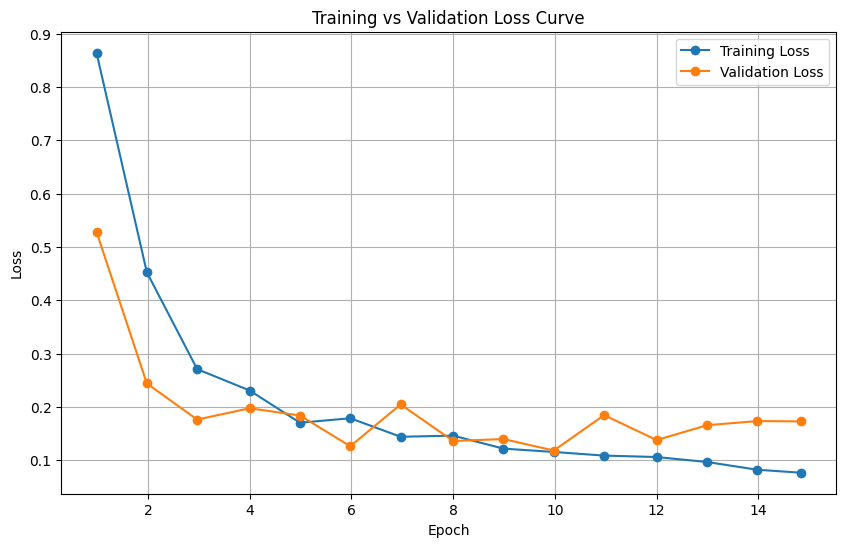

In [ ]:
plot_learning_curve(abnormalities_trainer)

### Evaluate Model

In [ ]:
abnormalities_metrics = evaluate_model(abnormalities_trainer)

***** eval metrics *****
  epoch                   =    14.8387
  eval_accuracy           =     0.9615
  eval_loss               =     0.1184
  eval_runtime            = 0:00:02.57
  eval_samples_per_second =    231.993
  eval_steps_per_second   =      7.383


In [ ]:
test_metrics = evaluate_on_test_set(abnormalities_trainer, abnormalities_test_ds)

Evaluating model on test dataset...
***** test metrics *****
  epoch                   =    14.8387
  eval_accuracy           =      0.903
  eval_loss               =     0.2229
  eval_runtime            = 0:00:00.85
  eval_samples_per_second =    193.547
  eval_steps_per_second   =      7.038


In [ ]:
print(abnormalities_train_ds.column_names)
print(abnormalities_train_ds[0])

['image', 'label']
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=600x656 at 0x7B5E50321AE0>, 'label': 0, 'pixel_values': tensor([[[-1.6384, -1.6384, -1.6555,  ..., -1.6384, -1.6555, -1.6555],
         [-1.6555, -1.6555, -1.6555,  ..., -1.6555, -1.6555, -1.6555],
         [-1.6555, -1.6555, -1.6555,  ..., -1.6555, -1.6555, -1.6555],
         ...,
         [-1.8953, -1.8953, -1.8953,  ..., -1.5185, -1.5870, -1.6727],
         [-1.9124, -1.9124, -1.8953,  ..., -1.5528, -1.6384, -1.6898],
         [-1.9124, -1.8953, -1.8953,  ..., -1.5870, -1.6727, -1.7069]],

        [[-1.5455, -1.5455, -1.5630,  ..., -1.5455, -1.5630, -1.5630],
         [-1.5630, -1.5630, -1.5630,  ..., -1.5630, -1.5630, -1.5630],
         [-1.5630, -1.5630, -1.5630,  ..., -1.5630, -1.5630, -1.5630],
         ...,
         [-1.8081, -1.8081, -1.8081,  ..., -1.4230, -1.4930, -1.5805],
         [-1.8256, -1.8256, -1.8081,  ..., -1.4580, -1.5455, -1.5980],
         [-1.8256, -1.8081, -1.8081,  ..., -1.4930,

In [ ]:
def create_label_mappings(dataset):
    """
    Create mappings from labels to IDs and vice versa.

    Args:
        dataset (Dataset): Dataset containing labeled data.

    Returns:
        tuple: A tuple containing two dictionaries, label2id and id2label.
    """
    labels = dataset.features["label"].names  
    label2id = {label: i for i, label in enumerate(labels)}
    id2label = {i: label for i, label in enumerate(labels)}

    return label2id, id2label

In [ ]:
# cross_validate_model(
#     model_checkpoint="microsoft/swin-tiny-patch4-window7-224",
#     dataset=abnormalities_train_ds,  
#     batch_size=32,
#     num_epochs=15,
#     model_name="swin-brain-abnormalities-classification"
# )

In [ ]:
# push_model_to_hub(abnormalities_trainer)

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

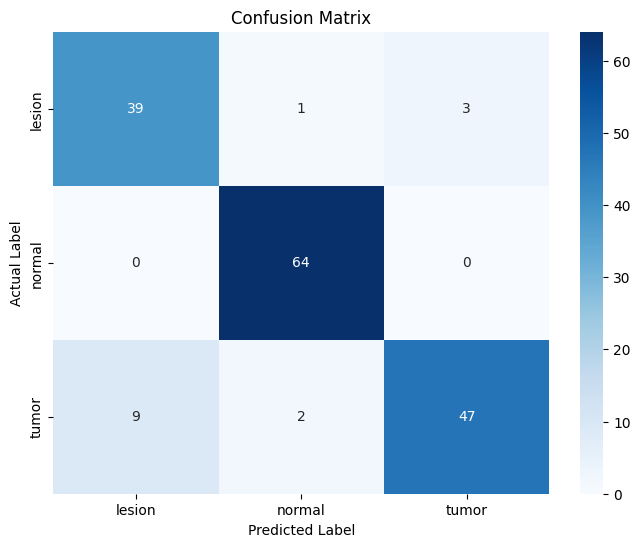

----- Classification Metrics -----
Precision (%): 91.27
Recall (%): 90.91
F1-Score (%): 90.83
Accuracy (%): 90.91


In [ ]:
plot_conf_matrix_and_metrics(
    dataset_name="bombshelll/brain_normal_vs_abnormal",
    repo_name="bombshelll/swin-brain-abnormalities-classification"
)

### Inference

In [ ]:
display_random_samples(abnormalities_dataset_name, repo_name="bombshelll/swin-brain-abnormalities-classification", num_samples=10)

## Brain Plane Classification

### Load Dataset and Label Mappings

In [ ]:
def create_label_mappings(dataset):
    """
    Create mappings from labels to IDs and vice versa.

    Args:
        dataset (Dataset or DatasetDict): Dataset containing labeled data.

    Returns:
        tuple: A tuple containing two dictionaries, label2id and id2label.
    """
    if isinstance(dataset, dict) or isinstance(dataset, DatasetDict):
        dataset = dataset["train"]

    labels = dataset.features["label"].names
    label2id = {label: i for i, label in enumerate(labels)}
    id2label = {i: label for i, label in enumerate(labels)}

    return label2id, id2label

In [ ]:
plane_dataset_name = "bombshelll/brain_plane"
plane_model_name = "swin-brain-plane-classification"
plane_dataset = load_dataset_from_hub(plane_dataset_name)

plane_label2id, plane_id2label = create_label_mappings(plane_dataset)

README.md:   0%|          | 0.00/627 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/12.6M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/2.79M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.53M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/630 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/135 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/135 [00:00<?, ? examples/s]

In [ ]:
plane_model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"
plane_image_processor = load_image_processor(plane_model_checkpoint)

plane_train_transforms, plane_val_transforms = create_transforms(plane_image_processor)

plane_train_ds = plane_dataset["train"]
plane_val_ds = plane_dataset["validation"]
plane_test_ds = plane_dataset["test"]

set_transforms(plane_train_ds, plane_train_ds, plane_train_transforms, plane_train_transforms)
set_transforms(plane_val_ds, plane_val_ds, plane_val_transforms, plane_val_transforms)
set_transforms(plane_test_ds, plane_test_ds, plane_val_transforms, plane_val_transforms)

# fraction = 0.75

# plane_train_ds = get_dataset_subset(plane_train_ds, fraction)
# plane_val_ds = get_dataset_subset(plane_val_ds, fraction)
# plane_test_ds = get_dataset_subset(plane_test_ds, fraction)

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

### Load Model and Set Training Arguments

In [ ]:
plane_model = load_model(plane_model_checkpoint, plane_label2id, plane_id2label)

plane_batch_size = 32
num_train_epoch = 10

plane_training_args = set_training_arguments(
    plane_model_checkpoint,
    plane_batch_size,
    plane_model_name,
    num_train_epoch
)

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Initialize Trainer and Train Model

In [ ]:
import shutil; shutil.rmtree("/kaggle/working/swin-brain-plane-classification", ignore_errors=True)

In [ ]:
plane_trainer = initialize_trainer(
    plane_model,
    plane_training_args,
    plane_train_ds,
    plane_val_ds,
    plane_image_processor
)

plane_train_results = train_model(plane_trainer)

Epoch,Training Loss,Validation Loss,Accuracy
1,1.060600,0.788663,0.874074
2,0.725600,0.394940,0.911111
3,0.433100,0.173064,0.970370
4,0.316500,0.124958,0.962963
5,0.182700,0.084743,0.970370
6,0.148800,0.091894,0.962963
7,0.142500,0.060407,0.977778
8,0.148700,0.071781,0.977778
9,0.118000,0.057757,0.977778
10,0.127800,0.055641,0.977778


model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =        10.0
  total_flos               = 145842420GF
  train_loss               =      0.3404
  train_runtime            =  0:01:22.61
  train_samples_per_second =      76.253
  train_steps_per_second   =       0.605


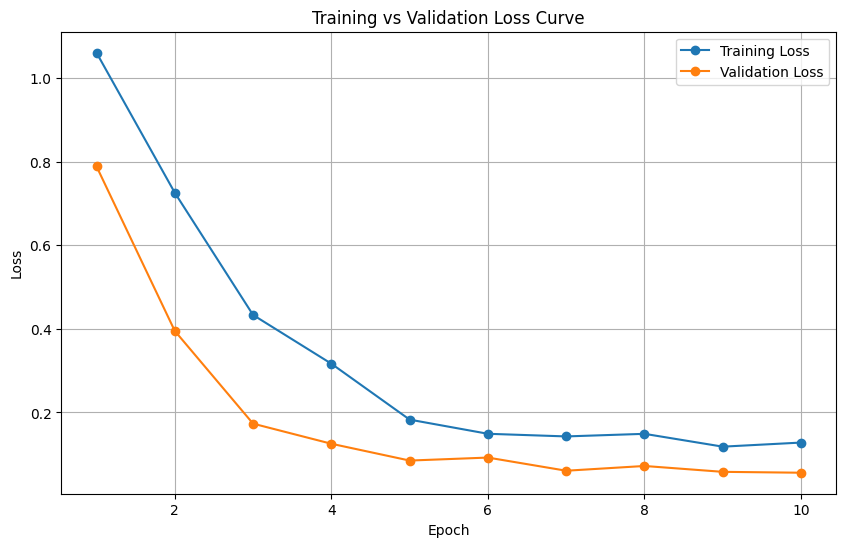

In [ ]:
plot_learning_curve(plane_trainer)

### Evaluate Model

In [ ]:
plane_metrics = evaluate_model(plane_trainer)

***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9778
  eval_loss               =     0.0604
  eval_runtime            = 0:00:00.73
  eval_samples_per_second =    183.043
  eval_steps_per_second   =      6.779


In [ ]:
test_metrics = evaluate_on_test_set(plane_trainer, plane_test_ds)

Evaluating model on test dataset...
***** test metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9778
  eval_loss               =     0.0583
  eval_runtime            = 0:00:00.69
  eval_samples_per_second =    194.827
  eval_steps_per_second   =      7.216


In [ ]:
# from datasets import DatasetDict

# cross_validate_model(
#     model_checkpoint="microsoft/swin-tiny-patch4-window7-224",
#     dataset=plane_train_ds,
#     batch_size=32,
#     num_epochs=10,
#     model_name="swin-brain-plane-classification"
# )

In [ ]:
# push_model_to_hub(plane_trainer)

In [ ]:
# plot_loss(training_metrics=plane_trainer.state.log_history, title="Plane Classification Loss")

preprocessor_config.json:   0%|          | 0.00/337 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

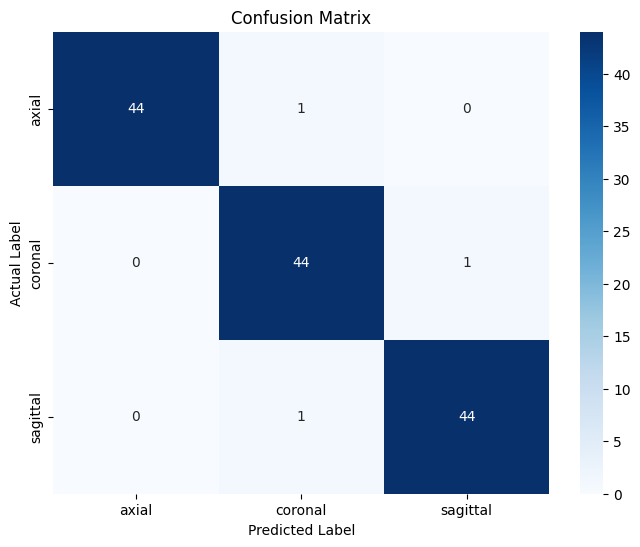

----- Classification Metrics -----
Precision (%): 97.81
Recall (%): 97.78
F1-Score (%): 97.79
Accuracy (%): 97.78


In [ ]:
plot_conf_matrix_and_metrics(
    dataset_name="bombshelll/brain_plane",
    repo_name="bombshelll/swin-brain-plane-classification"
)

In [ ]:
display_metrics(plane_metrics, plane_training_accuracy, title="Plane Classification Metrics")

### Display Random Samples

In [ ]:
display_random_samples(plane_dataset_name, repo_name="bombshelll/swin-brain-plane-classification", num_samples=10)

## Brain Modality Classification

### Load Dataset and Label Mappings

In [ ]:
modality_dataset_name = "bombshelll/brain_modality"
modality_model_name = "swin-brain-modality-classification"
modality_dataset = load_dataset_from_hub(modality_dataset_name)

modality_label2id, modality_id2label = create_label_mappings(modality_dataset)

README.md:   0%|          | 0.00/659 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/114M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/24.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2243 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/468 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/470 [00:00<?, ? examples/s]

### Load Image Processor and Create Transforms

In [ ]:
modality_model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"
modality_image_processor = load_image_processor(modality_model_checkpoint)

modality_train_transforms, modality_val_transforms = create_transforms(modality_image_processor)

modality_train_ds, modality_val_ds = split_dataset(modality_dataset)

set_transforms(modality_train_ds, modality_val_ds, modality_train_transforms, modality_val_transforms)

# fraction = 0.75

# modality_train_ds = get_dataset_subset(modality_train_ds, fraction)
# modality_val_ds = get_dataset_subset(modality_val_ds, fraction)

print(f"Total samples in Train Dataset: {len(modality_train_ds)}")
print(f"Total samples in Validation Dataset: {len(modality_val_ds)}")

Total samples in Train Dataset: 2018
Total samples in Validation Dataset: 225


In [ ]:
modality_model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"
modality_image_processor = load_image_processor(modality_model_checkpoint)

modality_train_transforms, modality_val_transforms = create_transforms(modality_image_processor)

modality_train_ds = modality_dataset["train"]
modality_val_ds = modality_dataset["validation"]
modality_test_ds = modality_dataset["test"]

set_transforms(modality_train_ds, modality_train_ds, modality_train_transforms, modality_train_transforms)
set_transforms(modality_val_ds, modality_val_ds, modality_val_transforms, modality_val_transforms)
set_transforms(modality_test_ds, modality_test_ds, modality_val_transforms, modality_val_transforms)

# fraction = 0.75

# modality_train_ds = get_dataset_subset(modality_train_ds, fraction)
# modality_val_ds = get_dataset_subset(modality_val_ds, fraction)
# modality_test_ds = get_dataset_subset(modality_test_ds, fraction)

print(f"Total samples in Train Dataset: {len(modality_train_ds)}")
print(f"Total samples in Validation Dataset: {len(modality_val_ds)}")

Total samples in Train Dataset: 2243
Total samples in Validation Dataset: 468


### Load Model and Set Training Arguments

In [ ]:
modality_model = load_model(modality_model_checkpoint, modality_label2id, modality_id2label)

modality_batch_size = 32
num_train_epoch = 3

modality_training_args = set_training_arguments(
    modality_model_checkpoint,
    modality_batch_size,
    modality_model_name,
    num_train_epoch
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Initialize Trainer and Train Model

In [ ]:
import shutil; shutil.rmtree("/kaggle/working/swin-brain-modality-classification", ignore_errors=True)

In [ ]:
modality_trainer = initialize_trainer(
    modality_model,
    modality_training_args,
    modality_train_ds,
    modality_val_ds,
    modality_image_processor
)

modality_train_results = train_model(modality_trainer)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.711600,0.146567,0.933333
2,0.095500,0.032321,0.991111
3,0.046400,0.019727,0.995556


***** train metrics *****
  epoch                    =         3.0
  total_flos               = 140151536GF
  train_loss               =      0.2845
  train_runtime            =  0:01:23.05
  train_samples_per_second =      72.893
  train_steps_per_second   =       0.578


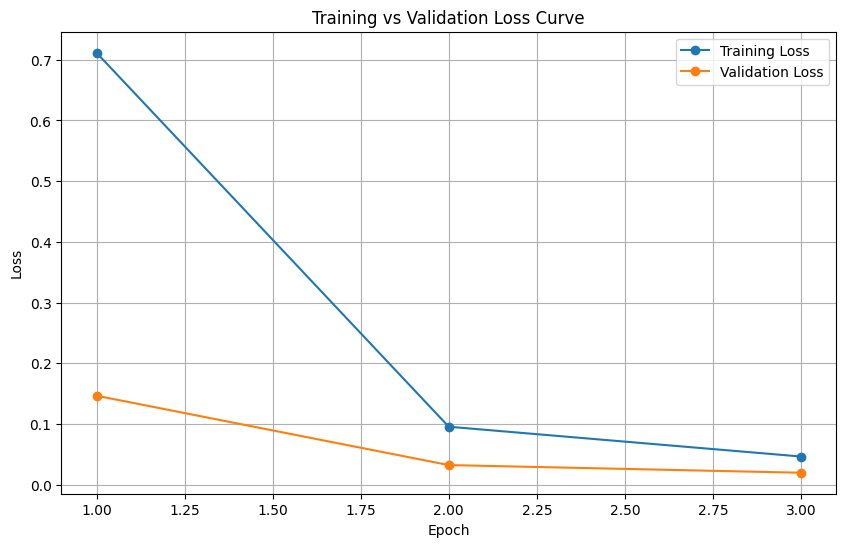

In [ ]:
plot_learning_curve(modality_trainer)

### Evaluate Model

In [ ]:
modality_metrics = evaluate_model(modality_trainer)

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.9956
  eval_loss               =     0.0197
  eval_runtime            = 0:00:01.83
  eval_samples_per_second =    122.421
  eval_steps_per_second   =      4.353


In [ ]:
test_metrics = evaluate_on_test_set(modality_trainer, modality_test_ds)

Evaluating model on test dataset...
***** test metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.9979
  eval_loss               =     0.0156
  eval_runtime            = 0:00:03.66
  eval_samples_per_second =    128.337
  eval_steps_per_second   =      4.096


In [ ]:
# cross_validate_model(
#     model_checkpoint="microsoft/swin-tiny-patch4-window7-224",
#     dataset=modality_train_ds,
#     batch_size=32,
#     num_epochs=3,
#     model_name="swin-brain-modality-classification"
# )

In [ ]:
# push_model_to_hub(modality_trainer)

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

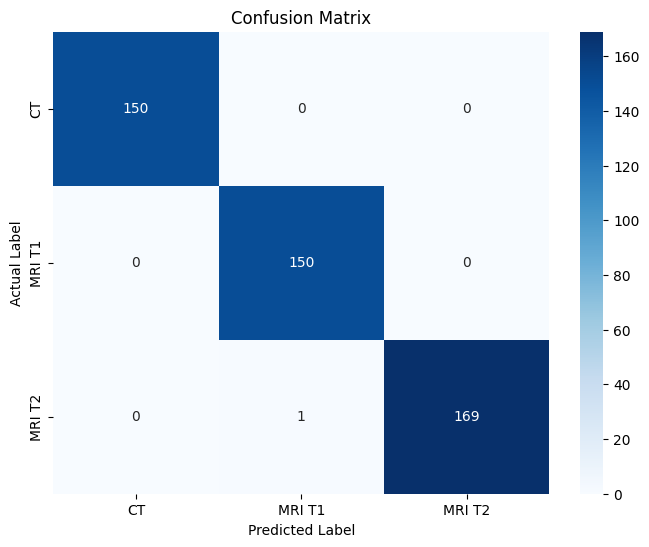

----- Classification Metrics -----
Precision (%): 99.79
Recall (%): 99.79
F1-Score (%): 99.79
Accuracy (%): 99.79


In [ ]:
plot_conf_matrix_and_metrics(
    dataset_name="bombshelll/brain_modality",
    repo_name="bombshelll/swin-brain-modality-classification"
)

### Display Random Samples

In [ ]:
display_random_samples(modality_dataset_name, repo_name="bombshelll/swin-brain-modality-classification", num_samples=10)

## Brain Tumor Type Classification

### Load Dataset and Label Mappings

In [ ]:
tumor_type_dataset_name = "bombshelll/brain_14_tumor_classes"
tumor_type_model_name = "swin-brain-tumor-type-classification"
tumor_type_dataset = load_dataset_from_hub(tumor_type_dataset_name)

tumor_type_label2id, tumor_type_id2label = create_label_mappings(tumor_type_dataset)

README.md:   0%|          | 0.00/951 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/116M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/25.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/25.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2672 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/566 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/589 [00:00<?, ? examples/s]

### Load Image Processor and Create Transforms

In [ ]:
tumor_type_model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"
tumor_type_image_processor = load_image_processor(tumor_type_model_checkpoint)

tumor_type_train_transforms, tumor_type_val_transforms = create_transforms(tumor_type_image_processor)

tumor_type_train_ds = tumor_type_dataset["train"]
tumor_type_val_ds = tumor_type_dataset["validation"]
tumor_type_test_ds = tumor_type_dataset["test"]

set_transforms(tumor_type_train_ds, tumor_type_train_ds, tumor_type_train_transforms, tumor_type_train_transforms)
set_transforms(tumor_type_val_ds, tumor_type_val_ds, tumor_type_val_transforms, tumor_type_val_transforms)
set_transforms(tumor_type_test_ds, tumor_type_test_ds, tumor_type_val_transforms, tumor_type_val_transforms)

# fraction = 0.75

# tumor_type_train_ds = get_dataset_subset(tumor_type_train_ds, fraction)
# tumor_type_val_ds = get_dataset_subset(tumor_type_val_ds, fraction)
# tumor_type_test_ds = get_dataset_subset(tumor_type_test_ds, fraction)

### Load Model and Set Training Arguments

In [ ]:
tumor_type_model = load_model(tumor_type_model_checkpoint, tumor_type_label2id, tumor_type_id2label)

tumor_type_batch_size = 32
num_train_epoch = 25

tumor_type_training_args = set_training_arguments(
    tumor_type_model_checkpoint,
    tumor_type_batch_size,
    tumor_type_model_name,
    num_train_epoch
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([14]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([14, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Initialize Trainer and Train Model

In [ ]:
import shutil; shutil.rmtree("/kaggle/working/swin-brain-tumor-type-classification", ignore_errors=True)

In [ ]:
tumor_type_trainer = initialize_trainer(
    tumor_type_model,
    tumor_type_training_args,
    tumor_type_train_ds,
    tumor_type_val_ds,
    tumor_type_image_processor
)

tumor_type_train_results = train_model(tumor_type_trainer)

Epoch,Training Loss,Validation Loss,Accuracy
1,2.482400,2.255820,0.242049
2,2.121300,1.816519,0.416961
3,1.661300,1.367764,0.567138
4,1.323700,1.193950,0.606007
5,1.154300,0.920513,0.704947
6,0.931700,0.812103,0.731449
7,0.789100,0.655286,0.798587
8,0.681200,0.571959,0.818021
9,0.634800,0.536394,0.818021
10,0.548800,0.478043,0.842756


***** train metrics *****
  epoch                    =         25.0
  total_flos               = 1546867941GF
  train_loss               =       0.6888
  train_runtime            =   0:15:17.18
  train_samples_per_second =       72.832
  train_steps_per_second   =        0.572


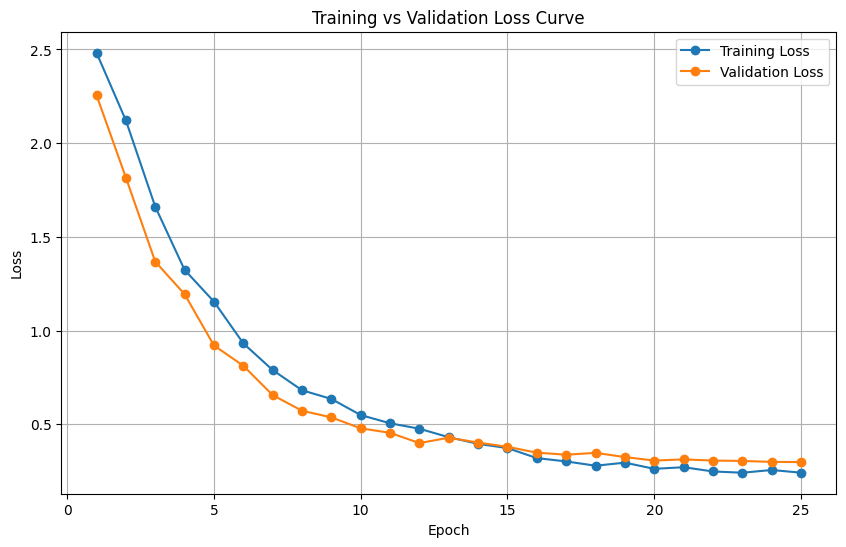

In [ ]:
plot_learning_curve(tumor_type_trainer)

### Evaluate Model

In [ ]:
tumor_type_metrics = evaluate_model(tumor_type_trainer)

***** eval metrics *****
  epoch                   =       25.0
  eval_accuracy           =     0.9099
  eval_loss               =      0.304
  eval_runtime            = 0:00:04.15
  eval_samples_per_second =    136.331
  eval_steps_per_second   =      4.336


In [ ]:
test_metrics = evaluate_on_test_set(tumor_type_trainer, tumor_type_test_ds)

Evaluating model on test dataset...
***** test metrics *****
  epoch                   =       25.0
  eval_accuracy           =     0.9083
  eval_loss               =     0.2876
  eval_runtime            = 0:00:04.37
  eval_samples_per_second =    134.686
  eval_steps_per_second   =      4.345


In [ ]:
# cross_validate_model(
#     model_checkpoint="microsoft/swin-tiny-patch4-window7-224",
#     dataset=tumor_type_train_ds,
#     batch_size=32,
#     num_epochs=25,
#     model_name="swin-brain-tumor-classification"
# )

In [ ]:
# push_model_to_hub(tumor_type_trainer)

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

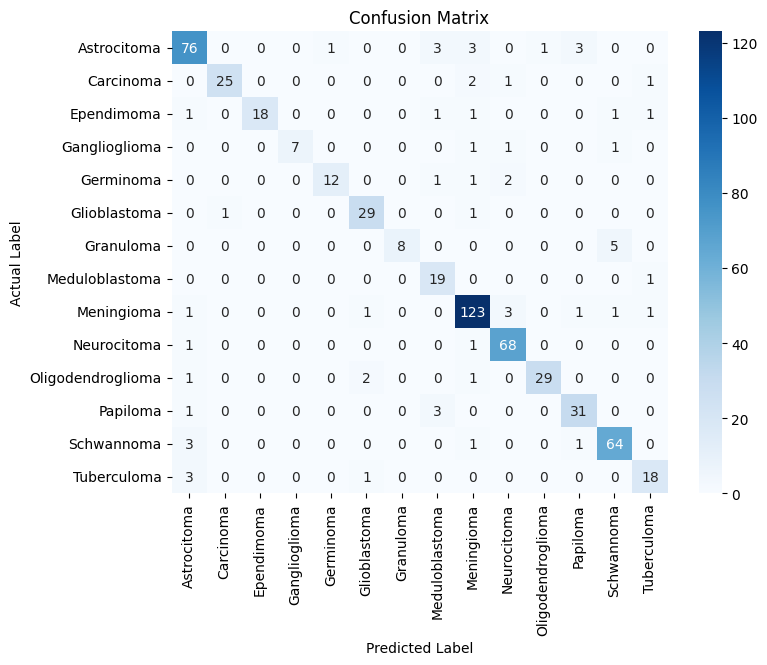

----- Classification Metrics -----
Precision (%): 90.01
Recall (%): 89.47
F1-Score (%): 89.40
Accuracy (%): 89.47


In [ ]:
plot_conf_matrix_and_metrics(
    dataset_name="bombshelll/brain_14_tumor_classes",
    repo_name="bombshelll/swin-brain-tumor-type-classification"
)

### Display Random Samples

In [ ]:
display_random_samples(tumor_type_dataset_name, repo_name="bombshelll/swin-brain-tumor-type-classification", num_samples=10)